## Data Preparation

Starting data preparation...
Found classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Creating data generators...
Found 2977 images belonging to 6 classes.
Found 639 images belonging to 6 classes.
Found 641 images belonging to 6 classes.

Exploring datasets...


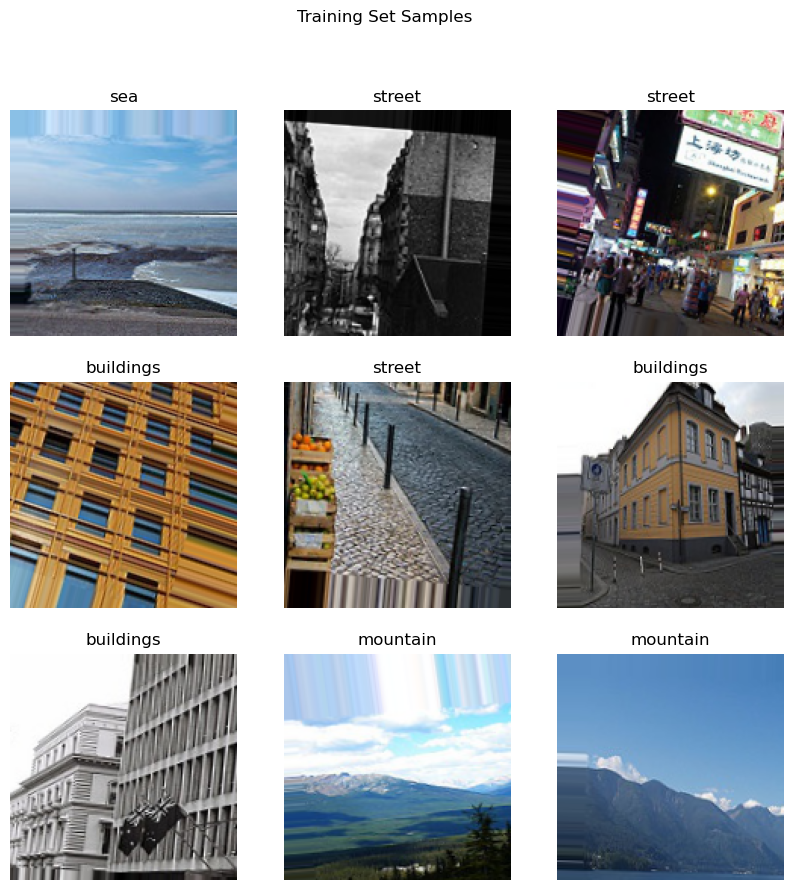

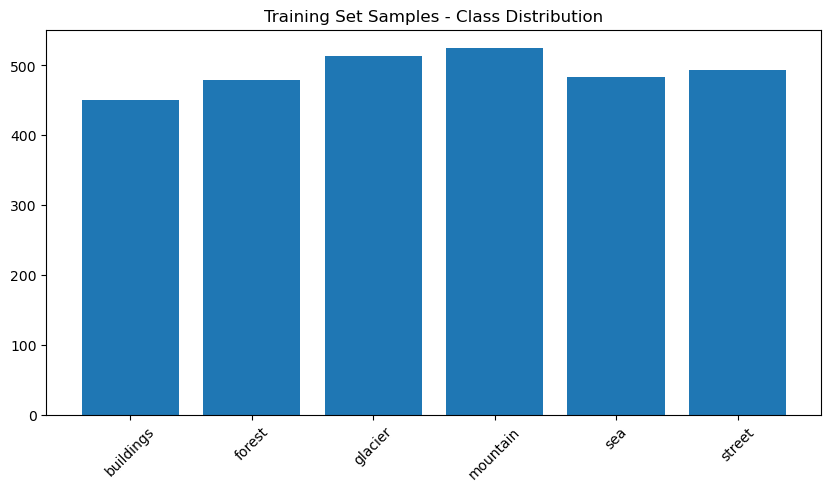

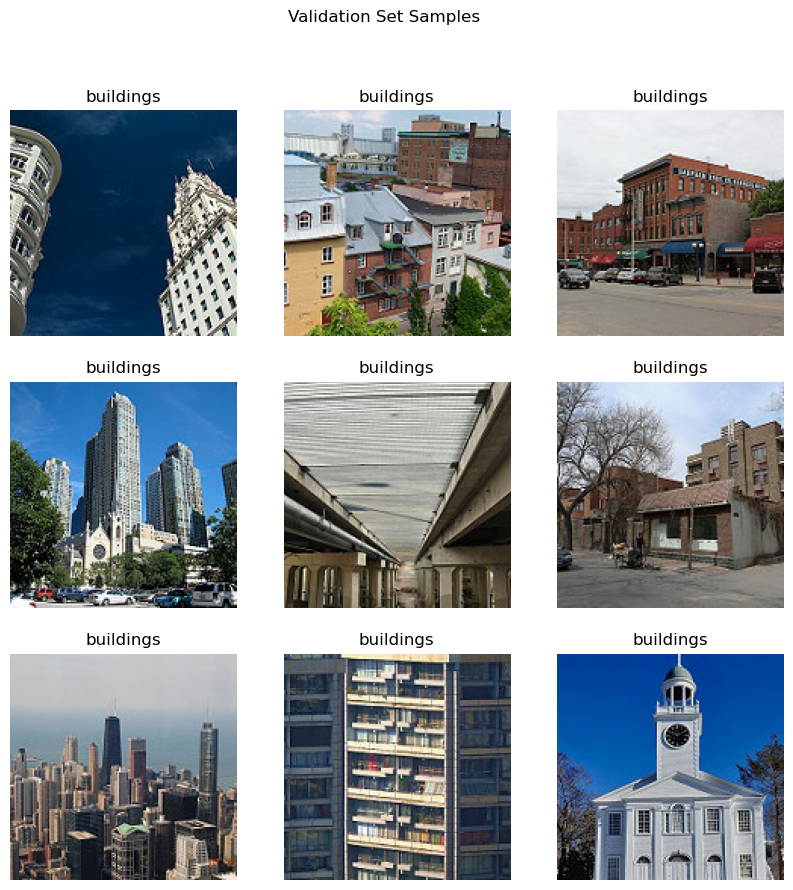

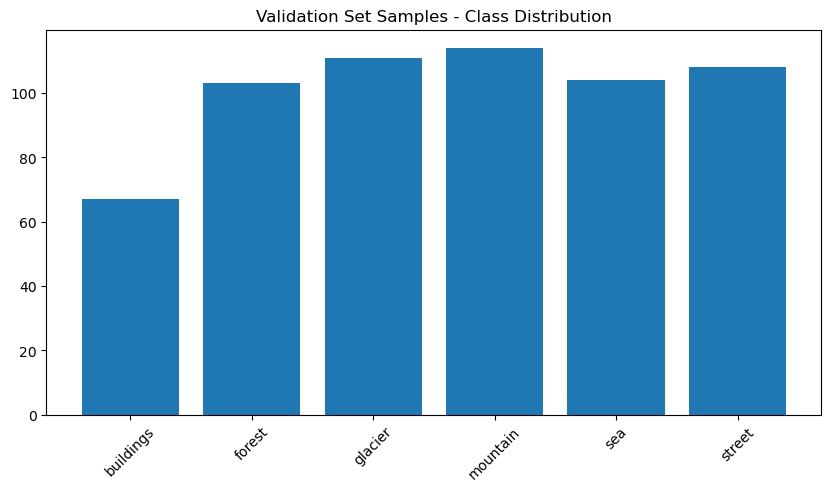

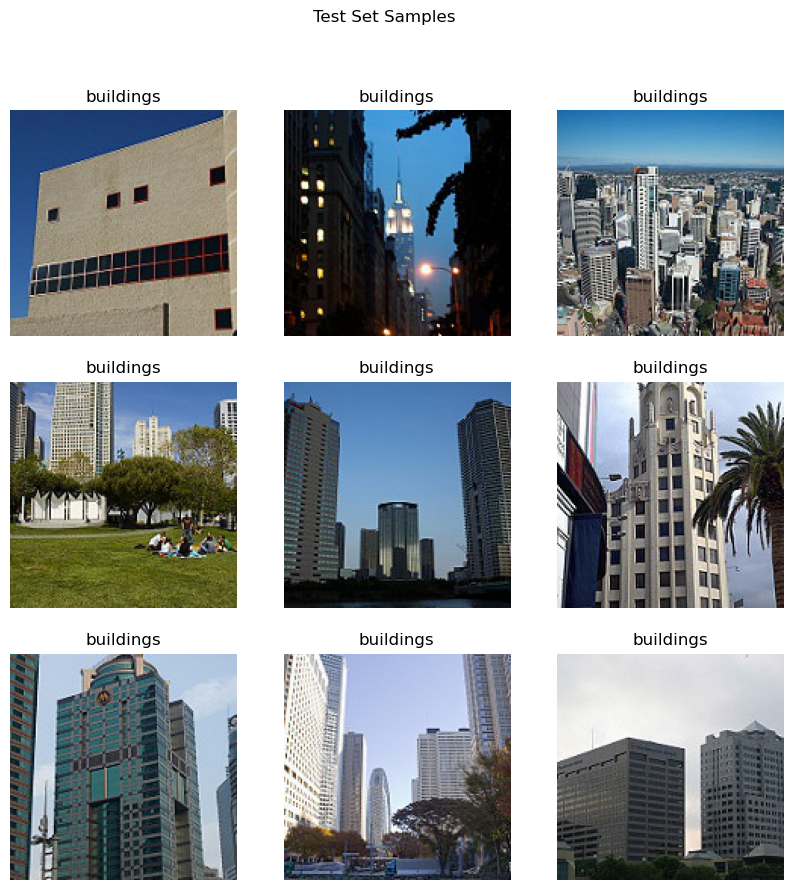

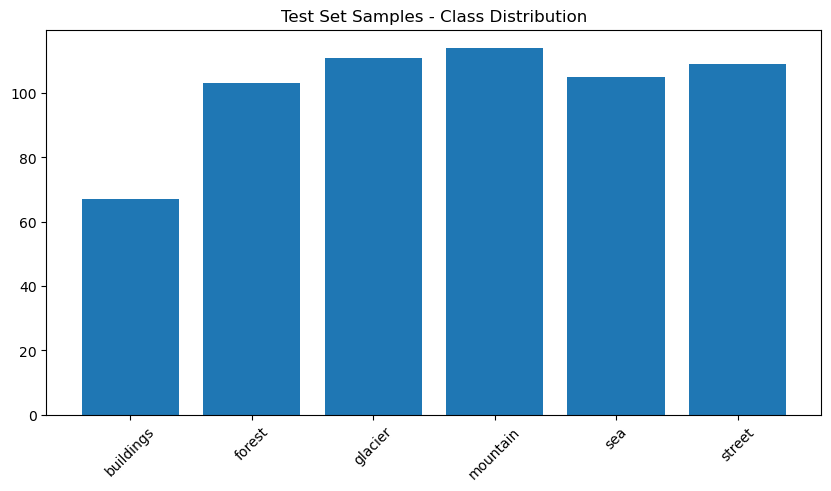


Data preparation complete!
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Training samples: 2977
Validation samples: 639
Test samples: 641


In [3]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Constants
DATASET_PATH = r"C:\Users\gregp\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2"
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
DATA_SUBSET_RATIO = 0.25  # Using 1/4 of the data
SEED = 42
TARGET_SIZE = (150, 150)
BATCH_SIZE = 32

def organize_and_split_subset(dataset_path, train_ratio, val_ratio, test_ratio, subset_ratio, seed=42):
    # Organize dataset with nested structure and create subsets
    # Create output directories
    train_dir = os.path.join(dataset_path, "train_subset")
    val_dir = os.path.join(dataset_path, "val_subset")
    test_dir = os.path.join(dataset_path, "test_subset")
    
    for dir_path in [train_dir, val_dir, test_dir]:
        os.makedirs(dir_path, exist_ok=True)
    
    # Correct paths for nested structure
    actual_train_path = os.path.join(dataset_path, "seg_train", "seg_train")
    actual_test_path = os.path.join(dataset_path, "seg_test", "seg_test")
    
    # Get class names
    class_names = sorted(os.listdir(actual_train_path))
    print(f"Found classes: {class_names}")
    
    for class_name in class_names:
        # Create class directories
        for subset_dir in [train_dir, val_dir, test_dir]:
            os.makedirs(os.path.join(subset_dir, class_name), exist_ok=True)
        
        # Get all images for this class
        train_images = [os.path.join(actual_train_path, class_name, f) 
                       for f in os.listdir(os.path.join(actual_train_path, class_name))]
        test_images = [os.path.join(actual_test_path, class_name, f)
                      for f in os.listdir(os.path.join(actual_test_path, class_name))]
        all_images = train_images + test_images
        
        # Take subset
        if len(all_images) > 1:  # Only split if we have multiple images
            subset_images, _ = train_test_split(all_images, train_size=subset_ratio, random_state=seed)
            
            # Split into train/val/test
            train_files, temp_files = train_test_split(subset_images, train_size=train_ratio, random_state=seed)
            val_files, test_files = train_test_split(temp_files, test_size=test_ratio/(val_ratio+test_ratio), random_state=seed)
            
            # Copy files
            for file in train_files:
                shutil.copy(file, os.path.join(train_dir, class_name, os.path.basename(file)))
            for file in val_files:
                shutil.copy(file, os.path.join(val_dir, class_name, os.path.basename(file)))
            for file in test_files:
                shutil.copy(file, os.path.join(test_dir, class_name, os.path.basename(file)))
        else:
            print(f"Warning: Not enough images in class {class_name} to split")
    
    return train_dir, val_dir, test_dir, class_names

def create_data_generators(train_dir, val_dir, test_dir, target_size, batch_size):
    # Create data generators with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator

def explore_dataset(generator, class_names, title):
    # Display sample images
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()
    
    # Show class distribution
    class_counts = {name: 0 for name in class_names}
    for _, label_batch in generator:
        for label in label_batch:
            class_counts[class_names[np.argmax(label)]] += 1
        if generator.batch_index == 0:
            break
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, [class_counts[name] for name in class_names])
    plt.title(f'{title} - Class Distribution')
    plt.xticks(rotation=45)
    plt.show()

if __name__ == "__main__":
    print("Starting data preparation...")
    train_dir, val_dir, test_dir, class_names = organize_and_split_subset(
        DATASET_PATH, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, DATA_SUBSET_RATIO, SEED
    )
    
    print("\nCreating data generators...")
    train_gen, val_gen, test_gen = create_data_generators(
        train_dir, val_dir, test_dir, TARGET_SIZE, BATCH_SIZE
    )
    
    print("\nExploring datasets...")
    explore_dataset(train_gen, class_names, "Training Set Samples")
    explore_dataset(val_gen, class_names, "Validation Set Samples")
    explore_dataset(test_gen, class_names, "Test Set Samples")
    
    print("\nData preparation complete!")
    print(f"Classes: {class_names}")
    print(f"Training samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")
    print(f"Test samples: {test_gen.samples}")

## ResNet Model


Building ResNet model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 150, 150)          │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 150, 150)          │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 150, 150)          │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stack (Stack)                 │ (None, 150, 150, 3)       │               0 │ get_item[0][0],            │
│                               │                           │                 │ get_item_1[0][0],          │
│                               │                           │                 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 150, 150, 3)       │               0 │ stack[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet50 (Functional)         │ (None, 2048)              │      23,587,712 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │         524,544 │ resnet50[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 6)                 │           1,542 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Training model...


C:\Users\gregp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.1957 - loss: 1.8878 - val_accuracy: 0.4053 - val_loss: 1.6561 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.2592 - loss: 1.6886 - val_accuracy: 0.4397 - val_loss: 1.5682 - learning_rate: 0.0010
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3120 - loss: 1.6121 - val_accuracy: 0.4460 - val_loss: 1.4608 - learning_rate: 0.0010
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3406 - loss: 1.5364 - val_accuracy: 0.4006 - val_loss: 1.4308 - learning_rate: 0.0010
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3471 - loss: 1.5028 - val_accuracy: 0.4585 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.3434 - loss: 1.4733 - val_accuracy: 0.4617 - val_loss: 1.3536 - learning_rate: 0.0010
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3689 - loss: 1.4519 - val_acc

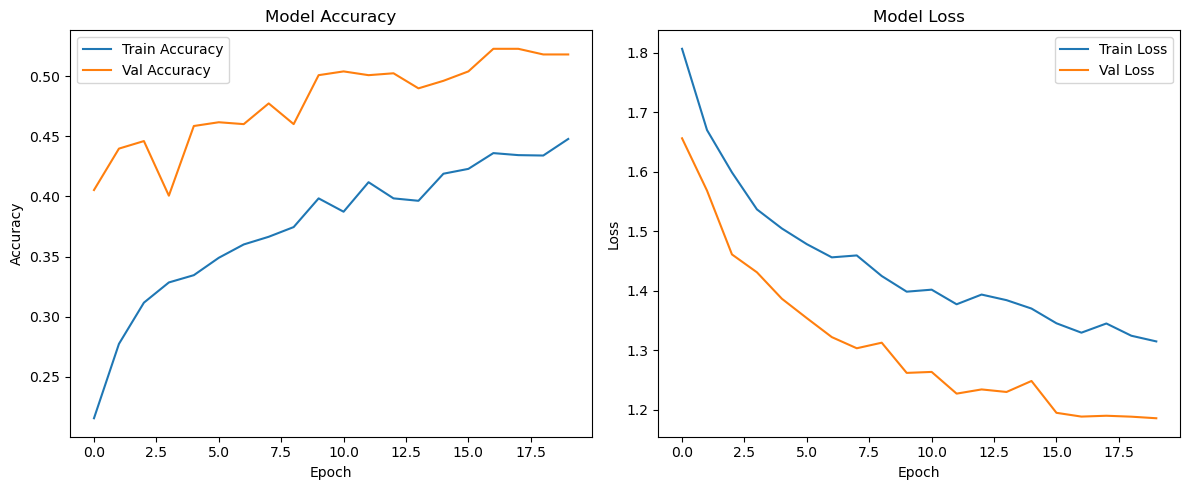


Evaluating on test set...
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5374 - loss: 1.1670


Test Accuracy: 0.5008
Test Loss: 1.2206

Model saved as 'intel_image_resnet.h5'


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Model Configuration
NUM_CLASSES = len(class_names)
LEARNING_RATE = 0.001
EPOCHS = 20

def build_resnet_model(input_shape, num_classes):
    """Build and compile ResNet50 model with custom top layers"""
    # Load pre-trained ResNet50 without top classification layer
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'  # Global average pooling
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create new model on top
    inputs = tf.keras.Input(shape=input_shape)
    
    # ResNet preprocessing (normalization expected by ResNet)
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    
    # Base model
    x = base_model(x, training=False)
    
    # Custom classification head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create complete model
    model = tf.keras.Model(inputs, outputs)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_model(model, train_gen, val_gen, epochs):
    # train model
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3,
            verbose=1
        )
    ]
    
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_gen):
    # Evaluate model on the test set
    print("\nEvaluating on test set...")
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

# Main execution
if __name__ == "__main__":
    # Input shape from Task 1 generators
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    
    print("\nBuilding ResNet model...")
    model = build_resnet_model(input_shape, NUM_CLASSES)
    model.summary()
    
    print("\nTraining model...")
    history = train_model(model, train_gen, val_gen, EPOCHS)
    
    print("\nTraining complete. Plotting history...")
    plot_training_history(history)
    
    # Evaluate on test set
    evaluate_model(model, test_gen)
    
    # Save the model
    model.save('intel_image_resnet.h5')
    print("\nModel saved as 'intel_image_resnet.h5'")

## Custom CNN


Building Custom CNN model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 150, 150, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 10,908,454 (41.61 MB)

 Trainable params: 10,907,046 (41.61 MB)

 Non-trainable params: 1,408 (5.50 KB)


Training Custom CNN model...
Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4007 - loss: 1.8931 - val_accuracy: 0.1628 - val_loss: 4.7341 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.5139 - loss: 1.3540 - val_accuracy: 0.1628 - val_loss: 5.0665 - learning_rate: 0.0010
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.5873 - loss: 1.1376 - val_accuracy: 0.1628 - val_loss: 5.9385 - learning_rate: 0.0010
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5933 - loss: 1.1344 - val_accuracy: 0.1628 - val_loss: 4.6344 - learning_rate: 0.0010
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.6052 - loss: 1.0568 - val_accuracy: 0.1628 - val_loss: 5.1516 - learning_rate: 0.0010
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.6478 - loss: 0.9626 - val_accuracy: 0.3114 - val_loss: 2.0072 - learning_rate: 0.0010
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0

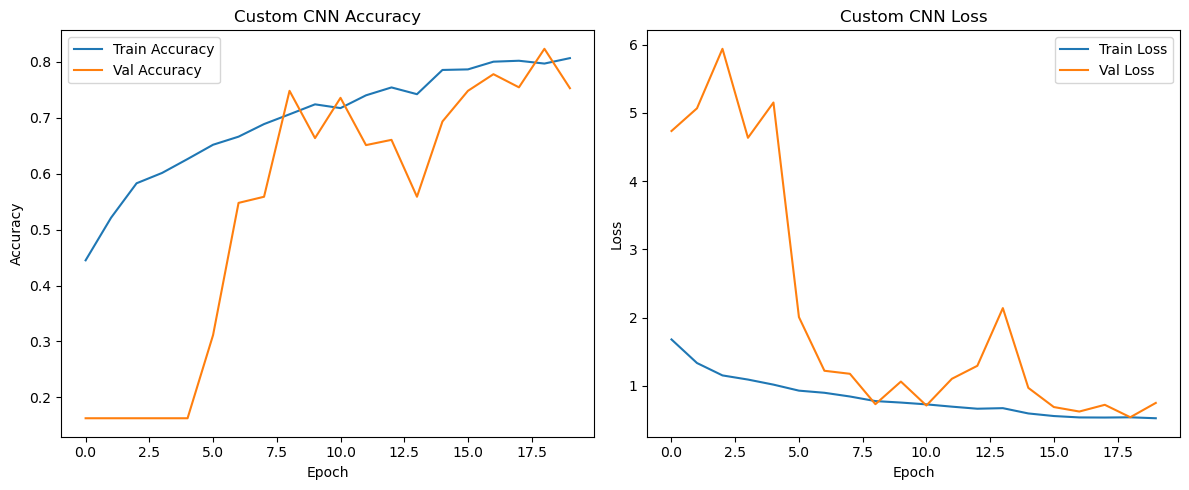


Evaluating on test set...
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 429ms/step - accuracy: 0.8263 - loss: 0.5396


Test Accuracy: 0.8144
Test Loss: 0.5652

Model saved as 'intel_image_custom_cnn.h5'


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Model Configuration
NUM_CLASSES = len(class_names)
LEARNING_RATE = 0.001
EPOCHS = 20

def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Normalize pixel values
        layers.Rescaling(1./255),
        
        # First Conv Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Second Conv Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Third Conv Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Classifier Head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_and_evaluate_model():
    # Input shape from Task 1 generators
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    
    print("\nBuilding Custom CNN model...")
    global cnn_model
    cnn_model = build_custom_cnn(input_shape, NUM_CLASSES)
    cnn_model.summary()
    
    # Same callbacks as Task 2 for fair comparison
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3,
            verbose=1
        )
    ]
    
    print("\nTraining Custom CNN model...")
    history = cnn_model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )
    
    print("\nTraining complete. Plotting history...")
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Custom CNN Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Custom CNN Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_loss, test_acc = cnn_model.evaluate(test_gen, verbose=1)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Save the model
    cnn_model.save('intel_image_custom_cnn.h5')
    print("\nModel saved as 'intel_image_custom_cnn.h5'")

if __name__ == "__main__":
    train_and_evaluate_model()

## Evaluation and Analysis


        Intel Image Classification: Model Evaluation        

RESNET50 MODEL EVALUATION
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

ResNet50 Classification Report
              precision    recall  f1-score   support

   buildings      0.480     0.495     0.488        99
      forest      0.624     0.806     0.703       103
     glacier      0.447     0.414     0.430       111
    mountain      0.425     0.272     0.332       114
         sea      0.440     0.562     0.494       105
      street      0.552     0.486     0.517       109

    accuracy                          0.501       641
   macro avg      0.495     0.506     0.494       641
weighted avg      0.493     0.501     0.491       641



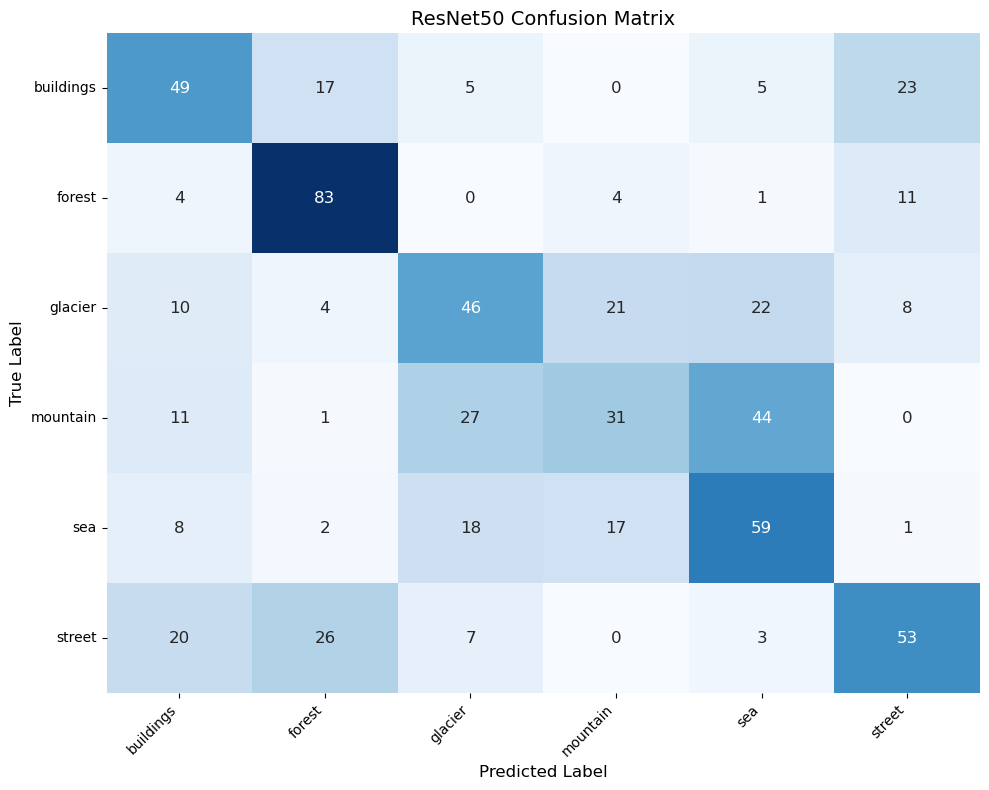

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


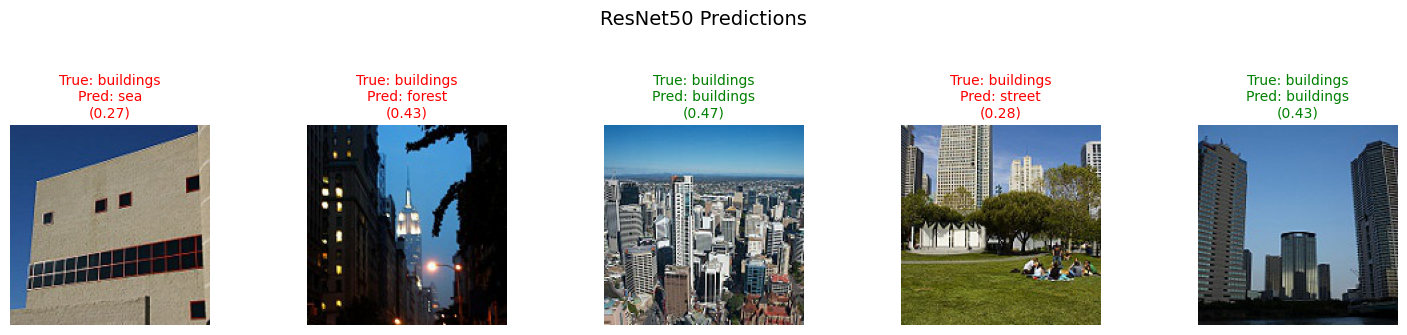


CUSTOM CNN MODEL EVALUATION
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step

Custom CNN Classification Report
              precision    recall  f1-score   support

   buildings      0.839     0.788     0.812        99
      forest      0.800     0.971     0.877       103
     glacier      0.769     0.811     0.789       111
    mountain      0.786     0.711     0.747       114
         sea      0.864     0.848     0.856       105
      street      0.840     0.771     0.804       109

    accuracy                          0.814       641
   macro avg      0.816     0.816     0.814       641
weighted avg      0.816     0.814     0.813       641



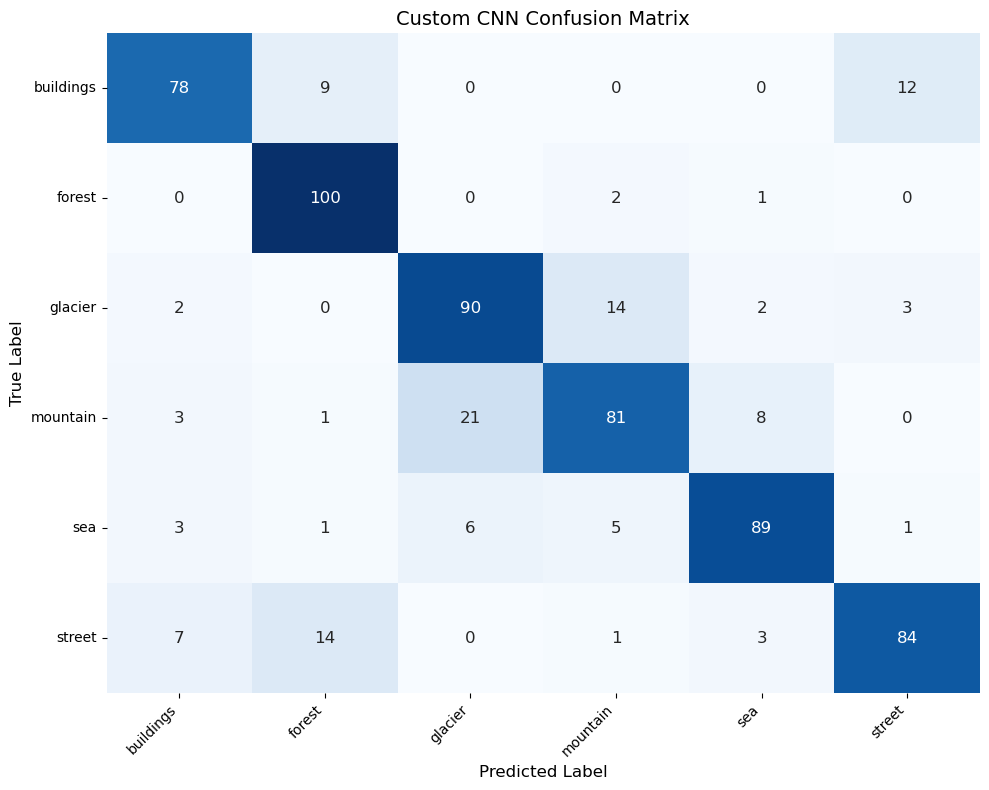

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


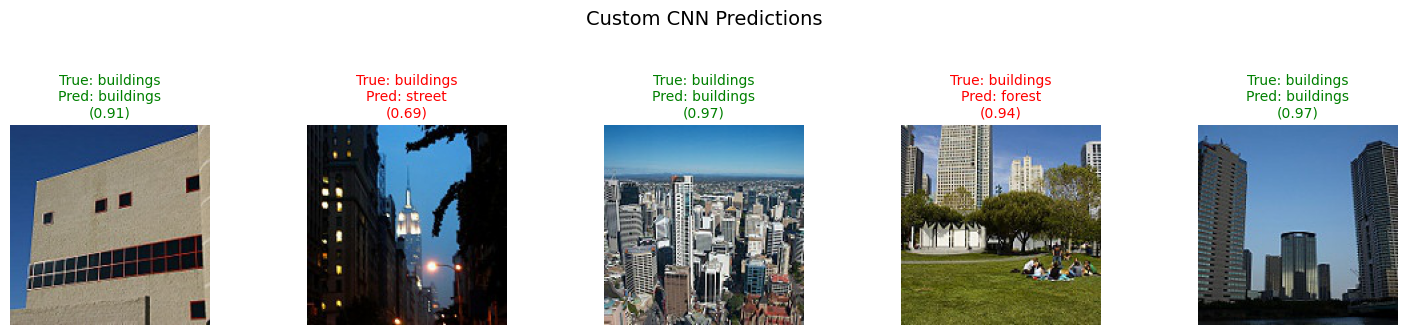


Comparative Performance Metrics
+-----------+---------------+------------+--------------+-----------+-------------+----------+
|   Class   |   ResNet Prec |   CNN Prec |  ResNet Rec  |  CNN Rec  |  ResNet F1  |  CNN F1  |
+===========+===============+============+==============+===========+=============+==========+
| buildings |         0.48  |      0.839 |    0.495     |   0.788   |    0.488    |  0.812   |
+-----------+---------------+------------+--------------+-----------+-------------+----------+
|  forest   |         0.624 |      0.8   |    0.806     |   0.971   |    0.703    |  0.877   |
+-----------+---------------+------------+--------------+-----------+-------------+----------+
|  glacier  |         0.447 |      0.769 |    0.414     |   0.811   |    0.430    |  0.789   |
+-----------+---------------+------------+--------------+-----------+-------------+----------+
| mountain  |         0.425 |      0.786 |    0.272     |   0.711   |    0.332    |  0.747   |
+-----------+----

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate

# ========== TASK 4: EVALUATION METRICS ==========
def generate_classification_report(model, test_gen, class_names, model_name):
    """Generate comprehensive evaluation metrics"""
    test_gen.reset()
    y_true = test_gen.classes
    y_pred = model.predict(test_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print(f"\n\033[1m{model_name} Classification Report\033[0m")
    print("="*50)
    print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=3))
    
    return y_true, y_pred_classes

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """Visualize confusion matrix with annotations"""
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}, cbar=False)
    plt.title(f'{model_name} Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def visualize_model_predictions(model, test_gen, class_names, model_name, num_samples=5):
    """Show example predictions with confidence scores"""
    test_gen.reset()
    images, labels = next(test_gen)
    preds = model.predict(images)
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        true_class = class_names[np.argmax(labels[i])]
        pred_class = class_names[np.argmax(preds[i])]
        confidence = np.max(preds[i])
        
        title_color = 'green' if true_class == pred_class else 'red'
        plt.title(f"True: {true_class}\nPred: {pred_class}\n({confidence:.2f})", 
                 color=title_color, fontsize=10)
        plt.axis('off')
    plt.suptitle(f'{model_name} Predictions', y=1.1, fontsize=14)
    plt.tight_layout()
    plt.show()

# ========== TASK 5: COMPARATIVE ANALYSIS ==========
def create_comparison_table(resnet_report, cnn_report, class_names):
    """Generate formatted comparison table"""
    comparison_data = []
    
    # Add class-wise metrics
    for cls in class_names:
        comparison_data.append([
            cls,
            f"{resnet_report[cls]['precision']:.3f}", f"{cnn_report[cls]['precision']:.3f}",
            f"{resnet_report[cls]['recall']:.3f}", f"{cnn_report[cls]['recall']:.3f}",
            f"{resnet_report[cls]['f1-score']:.3f}", f"{cnn_report[cls]['f1-score']:.3f}"
        ])
    
    # Add macro averages
    comparison_data.append([
        "Macro Avg",
        f"{resnet_report['macro avg']['precision']:.3f}", f"{cnn_report['macro avg']['precision']:.3f}",
        f"{resnet_report['macro avg']['recall']:.3f}", f"{cnn_report['macro avg']['recall']:.3f}",
        f"{resnet_report['macro avg']['f1-score']:.3f}", f"{cnn_report['macro avg']['f1-score']:.3f}"
    ])
    
    # Add accuracy
    comparison_data.append([
        "Accuracy",
        f"{resnet_report['accuracy']:.3f}", f"{cnn_report['accuracy']:.3f}",
        "", "", "", ""
    ])
    
    print("\n\033[1mComparative Performance Metrics\033[0m")
    print("="*70)
    print(tabulate(comparison_data,
                 headers=["Class", "ResNet Prec", "CNN Prec", "ResNet Rec", "CNN Rec",
                         "ResNet F1", "CNN F1"],
                 tablefmt="grid",
                 stralign="center"))

def perform_complete_analysis(resnet_model, cnn_model, test_gen, class_names):
    """Execute full evaluation pipeline"""
    print("\n\033[1m" + "="*60)
    print("Intel Image Classification: Model Evaluation".center(60))
    print("="*60 + "\033[0m")
    
    # Evaluate ResNet
    print("\n\033[1mRESNET50 MODEL EVALUATION\033[0m")
    resnet_true, resnet_pred = generate_classification_report(
        resnet_model, test_gen, class_names, "ResNet50")
    plot_confusion_matrix(resnet_true, resnet_pred, class_names, "ResNet50")
    visualize_model_predictions(resnet_model, test_gen, class_names, "ResNet50")
    
    # Evaluate CNN
    print("\n\033[1mCUSTOM CNN MODEL EVALUATION\033[0m")
    cnn_true, cnn_pred = generate_classification_report(
        cnn_model, test_gen, class_names, "Custom CNN")
    plot_confusion_matrix(cnn_true, cnn_pred, class_names, "Custom CNN")
    visualize_model_predictions(cnn_model, test_gen, class_names, "Custom CNN")
    
    # Generate comparison
    resnet_report = classification_report(
        resnet_true, resnet_pred, target_names=class_names, output_dict=True)
    cnn_report = classification_report(
        cnn_true, cnn_pred, target_names=class_names, output_dict=True)
    
    create_comparison_table(resnet_report, cnn_report, class_names)

# ========== MAIN EXECUTION ==========
if __name__ == "__main__":
    # Verify required variables exist
    required_vars = ['model', 'cnn_model', 'test_gen', 'class_names']
    missing = [var for var in required_vars if var not in globals()]
    
    if missing:
        print(f"Error: Missing required variables - {', '.join(missing)}")
        print("Please ensure you have:")
        print("- model (ResNet)")
        print("- cnn_model (Custom CNN)")
        print("- test_gen (Test data generator)")
        print("- class_names (List of class names)")
    else:
        perform_complete_analysis(model, cnn_model, test_gen, class_names)